# RHme2 still not SCAry challenge

This is an example of using Jlsca to analyze the trace set from the "moderate" SCA challenge of RHme2 embedded CTF (http://rhme.riscure.com/home).

The challenge features a somewhat protected SW AES-128 implementation on an 8-bit AVR microcontroller. You can send plaintext blocks to the device and receive blocks of ciphertext. The goal is to recover the encryption key.

Power traces were acquired using ChipWhisperer Lite and accompanying software (https://wiki.newae.com/Main_Page). The trigger was at the end of the cipher execution. 24400 samples preceding the trigger were acquired at 64 MS/s sampling rate to cover the last round of encryption.

A small tarball with traces is available at https://drive.google.com/open?id=0B2slHLSL3nXaZVBfQ3ZFZ1VCNGM, shasum `389d4047d213075eb570dce05a3455de509f1442`. Uncompress it next to this notebook.

In [1]:
# load the tools
using Jlsca.Sca
using Jlsca.Trs
using Jlsca.Align
using Jlsca.Aes
using PyCall
using PyPlot.plot,PyPlot.figure

@pyimport numpy

## Convert traces from ChipWhisperer capture to Trs format

Needed just once to create the trs file. The rest of the code uses the trs file.

In [2]:
# prefix identifying the capture, bulky as it is
# (so far have been lazy to automate based on ChipWhisperer config file)
prefix = "rhme2-stillnotscary-lastround/2017.01.26-17.08.39_"

# read the data from chipwhisperer capture
samples = numpy.load("$(prefix)traces.npy");
input = numpy.load("$(prefix)textin.npy");
output = numpy.load("$(prefix)textout.npy");

In [3]:
# get sizes
print(size(samples))
print(size(input))
print(size(output))

(101, 24400)(101, 16)(101, 16)

In [4]:
# set the parameters
numberOfTraces = size(input)[1]
numberOfSamples = size(samples)[2]
dataSpace = size(input)[2] + size(output)[2]
sampleType = Float32;

# create and save the trs
trs = InspectorTrace("rhme2-stillnotscary-lastround.trs", dataSpace, sampleType, numberOfSamples)
for t in 1:numberOfTraces
  trs[t] = (vcat(input[t,:],output[t,:]), map(Float32, samples[t,:]))
end
close(trs)

Creating Inspector trs file rhme2-stillnotscary-lastround.trs
#samples: 24400
#data:    32
type:     Float32
Wrote 101 traces in rhme2-stillnotscary-lastround.trs


## Explore the traces
To see if there are any interesting patterngs and how well they are aligned.

In [5]:
# load the traceset
trs = InspectorTrace("rhme2-stillnotscary-lastround.trs");

Opened rhme2-stillnotscary-lastround.trs, #traces 101, #samples 24400 (Float32), #data 32


In [6]:
# read 10 traces
((data,samples),eof) = readTraces(trs, 1:10);

Plot a single trace and then 3 traces overlayed

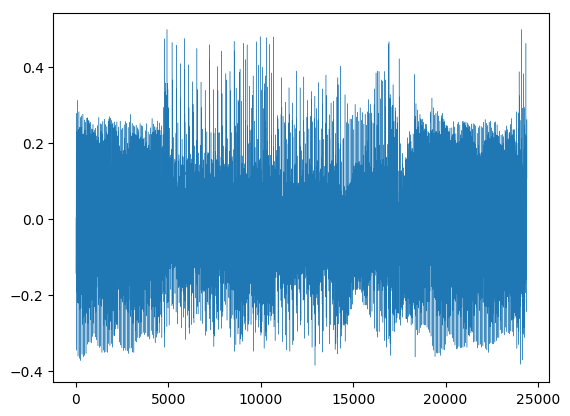

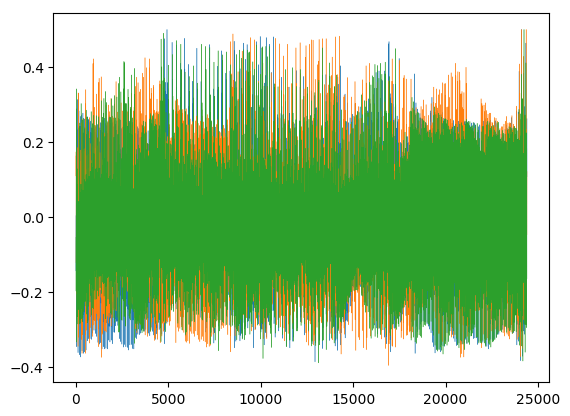

In [7]:
plot(samples[1,:],linewidth=.3);
figure();
plot(samples[1:3,:]',linewidth=.3); # note the transpose when plotting multiple traces

Round structure is visible. Traces are misaligned. We will fix that.

# Find good alignment
Playing with the start and end of the reference pattern, and keeping the rejection threshold at 0.

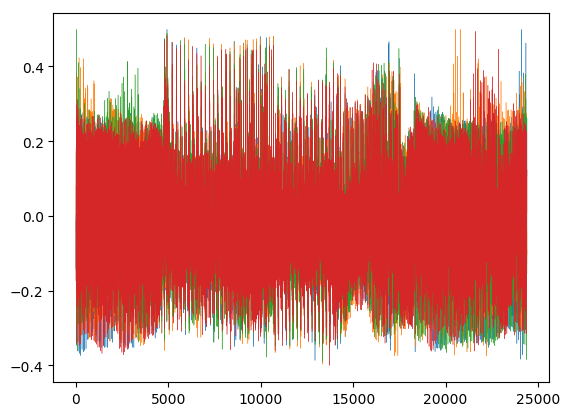

Processing traces .. 100%|██████████████████████████████| Time: 0:00:03


In [8]:
reset(trs)

# selecting the reference pattern in the first traces
referencestart = 5000
referenceend = referencestart + 5000
reference = trs[1][2][referencestart:referenceend]

# in the search of alignemt, traces will be shifted by max this amount of samples
maxShift = 20000

# the rejection threshold
corvalMin = 0.0

# create the alignment engine
alignstate = CorrelationAlignFFT(reference, referencestart, maxShift)

# add the alignment as a sample processing pass
# the end of the next line is somewhat complex I must say :) But it's an experimental toolbox, yay!
addSamplePass(trs, x -> ((shift,corval) = correlationAlign(x, alignstate); corval > corvalMin ? circshift(x, shift) : Vector{eltype(x)}(0)))

# execute the alignment pass by reading the traces
((data,samples),eof) = readTraces(trs, 1:4)

# remove the alignment apss
popSamplePass(trs)

# see what we've got
plot(samples[1:4,:]', linewidth=.3);

Aligned well! Let's close the trs for now.

In [9]:
close(trs)

## LRA attack with alignment

Let's run a non-profiled linear regression analysis instead of plain CPA just for fun. Though it will take some time and is not that necessary here. Vanilla CPA would do, and you can do it yourself as an excercise.

In [10]:
trs = InspectorTrace("rhme2-stillnotscary-lastround.trs")

numberOfTraces = length(trs);

Opened rhme2-stillnotscary-lastround.trs, #traces 101, #samples 24400 (Float32), #data 32


Prepare the alignment pass, bump the corvalMin to throw away stuff that is poorly aligned

In [11]:
maxShift = 20000
referencestart = 5000
referenceend = 10000
reference = trs[1][2][referencestart:referenceend]
corvalMin = 0.4
alignstate = CorrelationAlignFFT(reference, referencestart, maxShift)

addSamplePass(trs, x -> ((shift,corval) = correlationAlign(x, alignstate); corval > corvalMin ? circshift(x, shift) : Vector{eltype(x)}(0)));

# throwing away samples to speed up the LRA analysis (removing this pass does not affect the attack outcome)
addSamplePass(trs, x -> x[5000:9000])

Run with conditional averaging

In [12]:
reset(trs) # note, this resets the conditional averager, it doesn't pop the sample passes

params = DpaAttack(AesSboxAttack(), LRA())
params.dataOffset = 17       # ciphertext starts here
params.attack.direction = BACKWARD  # attack on last round from the ciphertext
params.analysis.basisModel = x -> basisModelSingleBits(x, 8)

setPostProcessor(trs, CondAvg())  
key = sca(trs, params, 1, numberOfTraces)


Jlsca running in Julia version: 0.6.1, 1 processes/1 workers/2 threads per worker

AES Sbox attack parameters
mode:       CIPHER
key length: KL128
direction:  BACKWARD
analysis:   LRA
basismodel: #7
data at:    17

phase: 1 / 1, #targets 16

Running processor "Cond avg" on trace range 1:1:101, 2 data passes, 2 sample passes

Averaged 101 input traces into 16 averages, UInt8 data type, Float64 sample type
LRA on samples shape (81, 4001) (range 1:4001) and data shape (81,)
Results @ 81 rows (101 traces consumed)
target: 1, phase: 1, "Inverse sbox out"
rank:   1, candidate: 0x4a, peak: 0.963259 @ 137
rank:   2, candidate: 0xc9, peak: 0.418260 @ 2005
rank:   3, candidate: 0x23, peak: 0.415857 @ 708
rank:   4, candidate: 0x6c, peak: 0.415228 @ 2649
rank:   5, candidate: 0xa0, peak: 0.410367 @ 3220
recovered key material: 4a
LRA on samples shape (84, 4001) (range 1:4001) and data shape (84,)
Results @ 84 rows (101 traces consumed)
target: 2, phase: 1, "Inverse sbox out"
rank:   1, candidate

16-element Array{UInt8,1}:
 0xd7
 0x0f
 0x5f
 0x3f
 0x85
 0xb2
 0x7c
 0xb6
 0x99
 0xc6
 0x16
 0x7e
 0xd6
 0x20
 0xbc
 0x3f

Check the key using a paintext-ciphertext pair from the traceset

In [13]:
w = KeyExpansion(key, 10, 4)
Cipher(trs[1][1][1:16], w) == trs[1][1][17:32] 

true

Here we are! Easy, isn't it?